# Data Science in Economics and Business - Class Project
In this class project, you are supposed to work with GDP data taken from the International Monetary Fund.

In this class project, you will use the different techniques taught in the course: data handling, data visualization, and machine learning.

First load the necessary packages. <br>
If you want to use additional libraries you can add them to the following cell:

In [54]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
sns.set()
import folium
from folium.plugins import MarkerCluster
import matplotlib.lines as mlines
import warnings
warnings.filterwarnings("ignore")

# Problem 1 - Data Handling
The basis of your work will be the following GDP dataset:

In [55]:
gdp = pd.read_csv("GDP_IMF.csv", sep=";")
gdp.head()

,Country,year,GDP
0,Afghanistan,1992,no data
1,Albania,1992,0.843
2,Algeria,1992,49.217
3,Andorra,1992,no data
4,Angola,1992,9.395


#### a)
As you can see, there are many missing values in the data. <br>
Before you can continue, you need to handle them. Proceed as follows:
- Delete those countries with no data at all (if any)
- Either delete the missing years for each country or use the years close by to approximate the missing value <br> *Example: Year 2004 is missing, but 2003 and 2005 are available; use the mean of GDP in 2003 and 2005 to replace missing year 2004.*

In [56]:
# check the format of the data
gdp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8436 entries, 0 to 8435
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Country  8436 non-null   object
 1   year     8436 non-null   int64 
 2   GDP      8436 non-null   object
dtypes: int64(1), object(2)
memory usage: 197.8+ KB


In [57]:
# convert GDP from object to number
gdp = pd.read_csv('GDP_IMF.csv', sep=";", na_values=['no data'])

gdp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8436 entries, 0 to 8435
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Country  8436 non-null   object 
 1   year     8436 non-null   int64  
 2   GDP      8204 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 197.8+ KB


In [58]:
# We group data by country
gdp_country = gdp.groupby("Country")

# for every country we create a single dataframe with its own data
dfs = [group for _, group in gdp_country]

In [59]:
# We fix problems with missing values

gdp_clean = pd.DataFrame()
rows_to_drop = []

for data in dfs:
    if np.isnan(data["GDP"].iloc[0]): # check first row
        rows_to_drop.append(data.index[0])
    
    for j in range(1, len(data) - 1):
        # check if current row is empty
        if np.isnan(data["GDP"].iloc[j]): # if it is, then I can do one of the following things
            if ~np.isnan(data["GDP"].iloc[j - 1]) and ~np.isnan(data["GDP"].iloc[j + 1]):
            # Replace NaN with the average of the GDP values before and after
                data["GDP"].iloc[j] = (data["GDP"].iloc[j - 1] + data["GDP"].iloc[j + 1]) / 2
            else:
                rows_to_drop.append(data.index[j])

    # Append the cleaned data to the gdp_clean DataFrame
    gdp_clean = gdp_clean.append(data)

gdp_clean.drop(rows_to_drop, inplace=True)
gdp_clean.reset_index(drop=True, inplace=True)

#### b)
We are only interested in the data on a country level and for years already passed. <br>
The dataset, however, also contains information on whole regions such as the EU or G7. <br>
It also contains predictions for GDP in the upcoming years. <br>
Delete these observations from the data. <br>
*Hint: Get a list of all unique values of the Country column.*

In [60]:
# save name of countries in a list and drop repetitions
country = gdp["Country"].unique().tolist()
# find index of a certain element
ind= country.index("Zimbabwe")

# delete list after Zimbabwe
not_country = country[ind+1:]
print(not_country)

['Africa (Region)', 'Asia and Pacific', 'Australia and New Zealand', 'Caribbean', 'Central America', 'Central Asia and the Caucasus', 'East Asia', 'Eastern Europe ', 'Europe', 'Middle East (Region)', 'North Africa', 'North America', 'Pacific Islands ', 'South America', 'South Asia', 'Southeast Asia', 'Sub-Saharan Africa (Region) ', 'Western Europe', 'Western Hemisphere (Region)', 'ASEAN-5', 'Advanced economies', 'Emerging and Developing Asia', 'Emerging and Developing Europe', 'Emerging market and developing economies', 'Euro area', 'European Union', 'Latin America and the Caribbean', 'Major advanced economies (G7)', 'Middle East and Central Asia', 'Other advanced economies', 'Sub-Saharan Africa', 'World']


In [61]:
# We delete observations relative to regions and future predictions
# Assuming that 2022 data are actual data and not forecasts, we drop data from 2023 onward
country_data = gdp_clean[~gdp_clean["Country"].isin(not_country) & (gdp_clean["year"] < 2023)]
country_data.head()


,Country,year,GDP
74,Afghanistan,2002,4.367
75,Afghanistan,2003,4.553
76,Afghanistan,2004,5.146
77,Afghanistan,2005,6.167
78,Afghanistan,2006,6.925


# Problem 2 - Data Visualization
#### a)
To get some first insights in the data, create meaningful plots. <br>
You can use any kind that you deem useful: histograms, line plots, etc.

We take data for Italian and German GDP and we plot them separately in two different subplots. The line graphs show the trends of GDP over time. We set a common scale to highlight the comparative economic performance in both countries. 

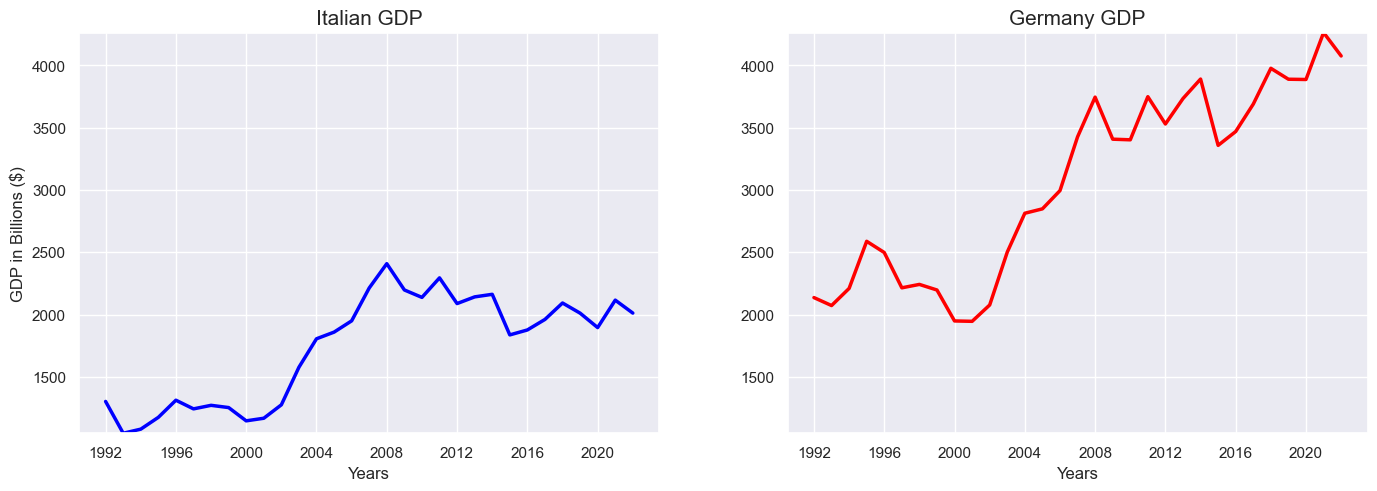

In [62]:
Italy_data =country_data[country_data ["Country"] == "Italy"].copy()
Germany_data =country_data[country_data ["Country"] == "Germany"].copy()

Italy_data['year'] = pd.to_datetime(Italy_data['year'], format='%Y')
Germany_data['year'] = pd.to_datetime(Germany_data['year'], format='%Y')

y_min = min(Italy_data["GDP"].min(), Germany_data["GDP"].min())
y_max = max(Italy_data["GDP"].max(), Germany_data["GDP"].max())

fig, ax = plt.subplots(1, 2, figsize=(15,6))
fig.tight_layout(pad=5.0)  # increase the spacing between subplots

# Italy's GDP
ax[0].plot(Italy_data["year"], Italy_data["GDP"], color='blue', linewidth=2.5)
ax[0].set_xlabel("Years", fontsize=12)
ax[0].set_ylabel("GDP in Billions ($)", fontsize=12)
ax[0].set_title("Italian GDP", fontsize=15)
ax[0].set_ylim([y_min, y_max])  # Set common y-axis
ax[0].grid(True)

# Germany's GDP
ax[1].plot(Germany_data["year"], Germany_data["GDP"], color='red', linewidth=2.5)
ax[1].set_xlabel("Years", fontsize=12)
ax[1].set_title("Germany GDP", fontsize=15)
ax[1].set_ylim([y_min, y_max])  # Set common y-axis
ax[1].grid(True)

plt.show()

Differently from above, here we plot both GDP trends in the same graph. It gives a clear and more visible comparison of the GDP growth between the two countries. 

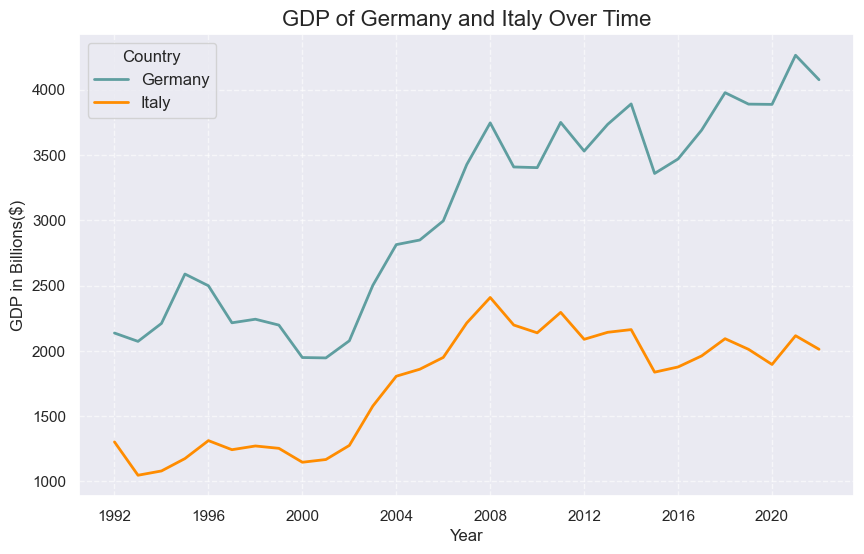

In [63]:
plt.figure(figsize=(10,6))

plt.plot(Germany_data["year"], Germany_data["GDP"], label="Germany", linewidth=2, color='cadetblue')
plt.plot(Italy_data["year"], Italy_data["GDP"], label="Italy", linewidth=2, color='darkorange')

plt.title('GDP of Germany and Italy Over Time', fontsize=16)
plt.xlabel('Year', fontsize=12)
plt.ylabel('GDP in Billions($)', fontsize=12)

plt.grid(True, linestyle='--', alpha=0.6)

plt.legend(loc="upper left", title="Country", fontsize=12, title_fontsize=12)

plt.show()


<div style="text-align: justify">
We now consider data relative to Greece.

The graph represents the trend of Greece's GDP over time, with periods of increase and decrease in GDP highlighted in green and red, respectively. To give further intuition, we added text and annotations to mark significant historical events that had an impact on Greece's GDP: the adoption of the Euro in 2000, the 2004 Summer Olympics, the global financial crisis in 2008, and the impact of Covid-19, starting from 2018.
This chart provides a visual representation of how Greece's economy has responded to these historical events.
    </div>

Text(-50, 40, '2004 Summer \nOlympics')

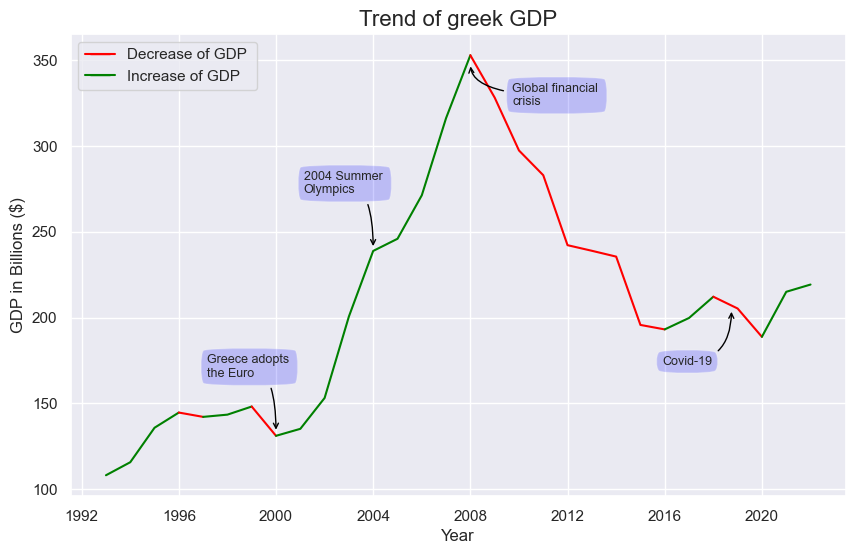

In [64]:
greece_data = country_data[country_data['Country'] == 'Greece']
greece_data = greece_data.copy()
greece_data['year'] = pd.to_datetime(greece_data['year'], format='%Y')
greece_data.set_index('year', inplace=True)
greece_data['GDP'] = pd.to_numeric(greece_data['GDP'], errors='coerce')
greece_data['GDP_diff'] = greece_data['GDP'].diff()
greece_data['increase'] = (greece_data['GDP_diff'] > 0)
greece_data.dropna(subset=['GDP_diff'], inplace=True)
greece_data['group'] = greece_data['increase'].diff().abs().cumsum().fillna(0).astype(int) + 1

fig, ax = plt.subplots(figsize=(10,6))


red = greece_data['increase'].iloc[1]
last = pd.DataFrame()

for i in range(greece_data['group'].max() + 1):
    group = pd.concat([last, greece_data[greece_data['group'] == i]])
    last = group.iloc[-1:]
    red = not red
    ax.plot(group.index, group['GDP'], color='red' if red else 'green')

ax.set_title('Trend of greek GDP', fontsize=16)
ax.set_xlabel('Year', fontsize=12)
ax.set_ylabel('GDP in Billions ($)',fontsize=12)

red_line = plt.Line2D([], [], color='red', marker='_', markersize=15, label='Decrease of GDP ')
green_line = plt.Line2D([], [], color='green', marker='_', markersize=15, label='Increase of GDP')
ax.legend(handles=[red_line, green_line],
          loc='upper left')

style = dict(size=9, color='black') 


ax.annotate("Global financial \ncrisis",
            xy=(pd.Timestamp("01-2008"), 348),
            xytext=(30, -30), 
            textcoords='offset points', 
            fontsize=9,
            bbox=dict(boxstyle="round4, pad=.5", fc="blue", alpha=0.2),
            arrowprops=dict(arrowstyle="->", ec="black",
                            connectionstyle="angle3,angleA=0,angleB=-90"))

ax.annotate("Greece adopts \nthe Euro",
            xy=(pd.Timestamp("01-2000"), 133),
            xytext=(-50, 40), 
            textcoords='offset points', 
            fontsize=9,
            bbox=dict(boxstyle="round4, pad=.5", fc="blue", alpha=0.2),
            arrowprops=dict(arrowstyle="->", ec="black",
                            connectionstyle="angle3,angleA=0,angleB=90"))

ax.annotate("Covid-19",
            xy=(pd.Timestamp("10-2018"), 205),
            xytext=(-50, -40), 
            textcoords='offset points', 
            fontsize=9,
            bbox=dict(boxstyle="round4, pad=.5", fc="blue", alpha=0.2),
            arrowprops=dict(arrowstyle="->", ec="black",
                            connectionstyle="angle3,angleA=0,angleB=-90"))

ax.annotate("2004 Summer \nOlympics",
            xy=(pd.Timestamp("01-2004"), 240),
            xytext=(-50, 40), 
            textcoords='offset points', 
            fontsize=9,
            bbox=dict(boxstyle="round4, pad=.5", fc="blue", alpha=0.2),
            arrowprops=dict(arrowstyle="->", ec="black",
                            connectionstyle="angle3,angleA=0,angleB=90"))



This chart provides a clear comparison of the economic size of the G7 countries in 2021. The given bar chart represents the Gross Domestic Product (GDP) in billions of dollars for the G7 countries in the year 2021.

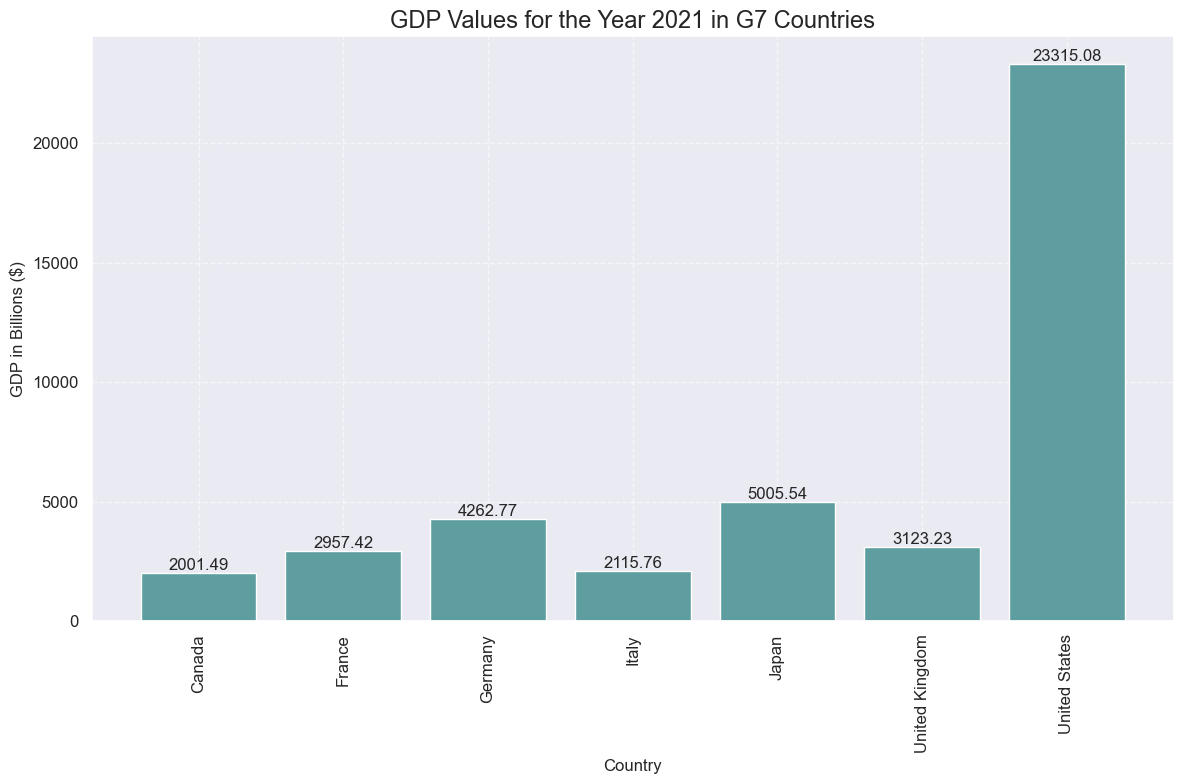

In [65]:
g7_countries = ['Canada', 'France', 'Germany', 'Italy', 'Japan', 'United Kingdom', 'United States']

g7_data = country_data[country_data['Country'].isin(g7_countries)]


g7_data_2021 = g7_data[g7_data['year'] == 2021]

plt.figure(figsize=(12, 8))

bar_container = plt.bar(g7_data_2021['Country'], g7_data_2021['GDP'], color='cadetblue')

for bar in bar_container:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.5, round(yval, 2), ha='center', va='bottom')

plt.grid(True, linestyle='--', alpha=0.6)

plt.xlabel('Country', fontsize=12)
plt.ylabel('GDP in Billions ($)', fontsize=12)
plt.title('GDP Values for the Year 2021 in G7 Countries', fontsize=17)

plt.xticks(rotation=90, fontsize=12)
plt.yticks(fontsize=12)

plt.tight_layout()
plt.show()

We again take the GDP of the G7 and we plot the trend. 
Each country is represented by a distinct line, allowing for a comparison of GDP trends over multiple years.

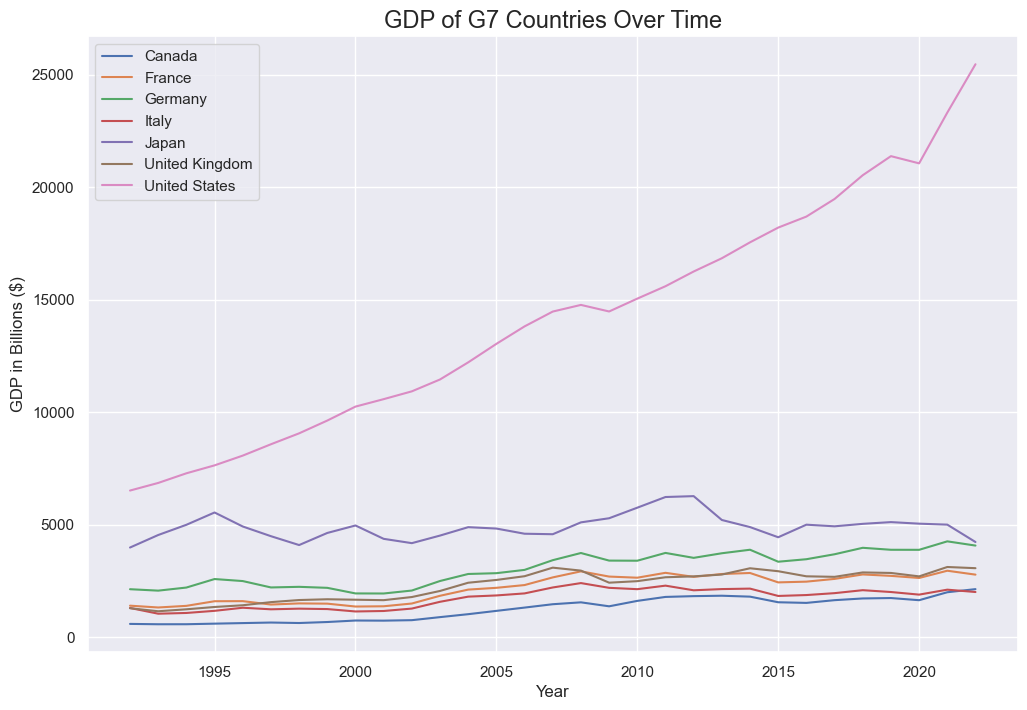

In [66]:
# Filter the data for the G7 countries
g7_countries = ['Canada', 'France', 'Germany', 'Italy', 'Japan', 'United Kingdom', 'United States']

g7_data = country_data[country_data['Country'].isin(g7_countries)]

# Get a list of unique years
years = g7_data['year'].unique()

# Create a figure and an axis
plt.figure(figsize=(12, 8))
ax = plt.gca()

# For each country in the G7, plot a line of their GDP over time
for country in g7_countries:
    country_data_a = g7_data[g7_data['Country'] == country]
    ax.plot(country_data_a['year'], country_data_a['GDP'], label=country)

# Set the title and labels
ax.set_title('GDP of G7 Countries Over Time', fontsize=17)
ax.set_xlabel('Year', fontsize=12)
ax.set_ylabel('GDP in Billions ($)', fontsize=12)


ax.legend()

plt.show()

We plot a horizontal bar chart which represents the top 10 countries by GDP in 2022. Each bar corresponds to a country, with the length of the bar indicating the GDP of that country in billions of dollars. The specific GDP value is displayed at the end of each bar for clarity.

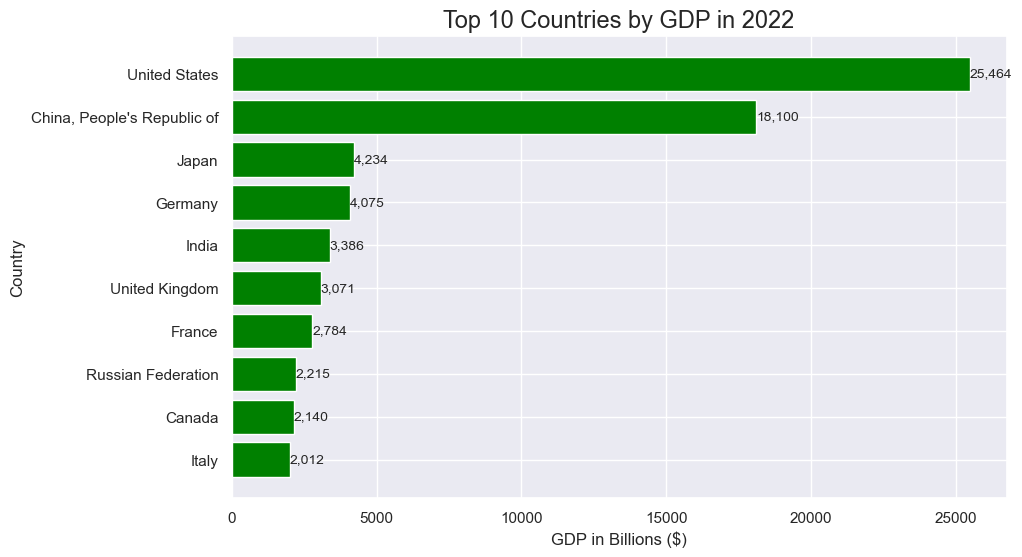

In [67]:
country_data['year'] = pd.to_datetime(country_data['year'], format='%Y')

data_2022 = country_data[country_data['year'].dt.year == 2022]

# Sort by GDP and take top 10
top_10 = data_2022.sort_values('GDP', ascending=False).head(10)

# Plot
plt.figure(figsize=(10, 6))
bars = plt.barh(top_10['Country'][::-1], top_10['GDP'][::-1], color='green')

# Add data labels
for bar in bars:
    plt.text(bar.get_width(), bar.get_y() + bar.get_height()/2, 
             f'{bar.get_width():,.0f}', 
             va='center', fontsize=10)

# Set labels and title
plt.xlabel('GDP in Billions ($)', fontsize=12)
plt.ylabel('Country', fontsize=12)
plt.title('Top 10 Countries by GDP in 2022', fontsize=17)

plt.show()


#### b)
Pick a year with as little missing values as possible. <br>
For this year, create an interactive map with `folium` that tells you the GDP in the country in the given year. <br>
*Hint: Be cautious with country names.*

In [68]:
year_count = country_data.year.value_counts()

print(year_count)

2017-01-01    195
2020-01-01    195
2018-01-01    195
2016-01-01    195
2015-01-01    195
2014-01-01    195
2013-01-01    195
2012-01-01    195
2011-01-01    195
2019-01-01    195
2010-01-01    194
2009-01-01    194
2008-01-01    194
2007-01-01    194
2006-01-01    194
2005-01-01    194
2004-01-01    194
2021-01-01    193
2002-01-01    193
2003-01-01    193
2022-01-01    193
2001-01-01    192
2000-01-01    191
1998-01-01    183
1999-01-01    183
1997-01-01    181
1996-01-01    179
1995-01-01    178
1994-01-01    174
1993-01-01    172
1992-01-01    170
Name: year, dtype: int64


We upload data for longitude and latitude of countries from https://github.com/albertyw/avenews/blob/master/old/data/average-latitude-longitude-countries.csv

In [69]:
# All years from 2011 to 2020 are those with the lowest number of missing values

data_2020 = country_data[country_data["year"].dt.year == 2020]

latlong_file = "paesilatilongi.csv"
latlong_data = pd.read_csv(latlong_file)
latlong_data  = latlong_data.rename(columns={'Country': 'country'})
latlong_data.drop("ISO 3166 Country Code", axis=1, inplace=True)
combined_data = pd.merge(data_2020, latlong_data, left_on="Country", right_on="country", how="left")
missings = combined_data[combined_data["country"].isnull()].index
not_found = combined_data.loc[missings]
not_found["Country"]

latlong_data_final = latlong_data.replace ({ "Bahamas": "Bahamas, The", 
                         "Cape Verde": "Cabo Verde",
                        "China":"China, People's Republic of",
                             "Congo, The Democratic Republic of the": "Congo, Dem. Rep. of the",
                                     "Congo":"Congo, Republic of ",         
                               "Swaziland":"Eswatini",
                                "Gambia":"Gambia, The",
                              "Hong Kong":"Hong Kong SAR",
                               "Iran, Islamic Republic of":"Iran",
                             "Kyrgyzstan":"Kyrgyz Republic",
                               "Lao People's Democratic Republic": "Lao P.D.R.",
                               "Libyan Arab Jamahiriya": "Libya",
                               "Macao":"Macao SAR",
                               "Micronesia, Federated States of":"Micronesia, Fed. States of",
                               "Moldova, Republic of":"Moldova",
                               "Macedonia":"North Macedonia ",
                                "Sao Tome and Principe": "Sao Tome und Principe",
                               "Slovakia":"Slovak Republic",
                             "Taiwan":"Taiwan Province of China",
                               "Tanzania, United Republic of":"Tanzania",
                                "Turkey":"Tuerkiye, Republic of",
                         "Palestinian Territory":"West Bank and Gaza"
                            })

combined_data = pd.merge(data_2020, latlong_data_final, left_on="Country", right_on="country", how="left")
                                                  
combined_data.Longitude[combined_data["Country"]=="Kosovo"] = 20.9030
combined_data.Latitude[combined_data["Country"]=="Kosovo"] = 42.6026
combined_data.Longitude[combined_data["Country"]=="South Sudan, Republic of"] = 31.3070
combined_data.Latitude[combined_data["Country"]=="South Sudan, Republic of"] = 6.8770
combined_data.Longitude[combined_data["Country"]=="Timor-Leste"] = 125.7275
combined_data.Latitude[combined_data["Country"]=="Timor-Leste"] = -8.8742

combined_data = combined_data.drop(columns=["country"])

missings = combined_data[combined_data["Latitude"].isnull()].index
not_found = combined_data.loc[missings]
not_found["Country"]

combined_data

,Country,year,GDP,Latitude,Longitude
0,Afghanistan,2020-01-01,20.136,33.0,65.00
1,Albania,2020-01-01,15.161,41.0,20.00
2,Algeria,2020-01-01,145.656,28.0,3.00
3,Andorra,2020-01-01,2.885,42.5,1.50
4,Angola,2020-01-01,57.139,-12.5,18.50
...,...,...,...,...,...
190,Vietnam,2020-01-01,346.310,16.0,106.00
191,West Bank and Gaza,2020-01-01,15.532,32.0,35.25
192,Yemen,2020-01-01,18.373,15.0,48.00
193,Zambia,2020-01-01,18.111,-15.0,30.00


This is an interactive folium map, which displays markers for different countries with their corresponding GDP data for the year 2020. <br>
The position of each marker is determined by the latitude and longitude of the country. The GDP data is displayed in a pop-up that appears when you click on a marker. Their colour changes depending on the value of GDP. <br>
The map gives a global view of economic prosperity, providing an intuitive way to understand and compare the economic sizes of different countries.

In [70]:
globe_map = folium.Map(location=[0, 0], zoom_start=2)


for lat, long, nation, gdp in zip(combined_data["Latitude"], combined_data["Longitude"], combined_data["Country"], combined_data["GDP"]):
    info = folium.Popup(f"{nation} 2020 GDP: <br>{gdp:.2f} billions US $", max_width=300)

    # Set marker color based on GDP value
    if pd.notna(gdp):  
        if 3000 <= gdp < 25000:
            marker_color = "blue"
        elif 2000 <= gdp <= 3000:
            marker_color = "lightblue"
        elif 1000 <= gdp < 2000:
            marker_color = "cadetblue"
        elif 500 <= gdp < 1000:
            marker_color = "lightgreen"
        elif 250 <= gdp < 500:
            marker_color = "green"
        elif 0 <= gdp < 250:
            marker_color = "lightred"
        else:
            marker_color = "red" 

    folium.Marker([lat, long], popup=info, icon=folium.Icon(color=marker_color)).add_to(globe_map)


globe_map


This folium map differs from the one before for some characteristics: the visual appearance of the map's background; the markers are circles and their radius corresponds to the GDP of the country it represents, providing another dimension to visualize the economic size of each country.

In [71]:
globe_map = folium.Map(location=[0, 0], zoom_start=2)

folium.TileLayer('cartodb positron').add_to(globe_map)

for lat, long, nation, gdp in zip(combined_data["Latitude"], combined_data["Longitude"], combined_data["Country"], combined_data["GDP"]):
    info = folium.Popup(f"{nation} 2020 GDP: <br>{gdp:.2f} billions US $", max_width=300)

    # We set marker color and radius based on GDP value
    if pd.notna(gdp):  
        if 3000 <= gdp < 25000:
            marker_color = "purple"
            radius = 10
        elif 2000 <= gdp <= 3000:
            marker_color = "lightblue"
            radius = 9
        elif 1000 <= gdp < 2000:
            marker_color = "cadetblue"
            radius = 8
        elif 500 <= gdp < 1000:
            marker_color = "green"
            radius = 7
        elif 250 <= gdp < 500:
            marker_color = "lightgreen"
            radius = 6
        elif 0 <= gdp < 250:
            marker_color = "red"
            radius = 5
        else:
            marker_color = "yellow" 
            radius = 4

        # We add a circle marker to the map
        folium.CircleMarker(
            location=[lat, long],
            radius=radius,
            popup=info,
            color=marker_color,
            fill=True,
            fill_color=marker_color,
            fill_opacity=0.6,
            line_opacity=0.2,
        ).add_to(globe_map)

globe_map


# Problem 3 - Supervised Machine Learning
#### a)
First, try to predict the GDP in a given year and in a given country using the data from the past years. <br>
Report the performance (measured in mean squared error) for different numbers of lags.

In [72]:
# We get the unique country names
unique_countries = country_data['Country'].unique()

# We create an empty list to store the dataframes
country_dfs = []

target_year = 2023

# We iterate over each country
for country in unique_countries:
    target_data = country_data[(country_data["Country"] == country) & (country_data["year"].dt.year < target_year)]
    target_data["Year"] = target_data.year.dt.year
    target_data.drop(columns="year", inplace=True)

    # Count the number of values for the current country
    num_values = target_data.shape[0]

    # We only add the processed dataframe to the list if it has at least 20 values
    if num_values >= 20:
        max_lag = 20
        for l in range(1, max_lag+1):
            target_data["GDP_lag"+str(l)] = target_data.GDP.shift(l)
        
        # We append the processed dataframe to the list
        country_dfs.append(target_data)

### Linear Regression

We try out Linear Regression.

In [73]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, confusion_matrix
from sklearn.model_selection import train_test_split

# We create a list to store results for each country
result_country = {}

max_lag = 20   

# We iterate over each country dataframe
for country_df in country_dfs:
    out = pd.DataFrame(np.zeros([max_lag, 3]))
    country_name= country_df["Country"].iloc[0]
    out.columns = ["Country","max_lag", "RMSE"]

    for lag in range(1, max_lag+1):
        if lag % 5 == 1:
            print("max_lag =", lag)
        X = country_df[["GDP_lag" + str(l) for l in range(1, lag+1)]].iloc[lag:]
        y = country_df["GDP"].iloc[lag:]
        X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=234)
    
        # Fit the linear regression model
        model = LinearRegression()
        model.fit(X_train, y_train)
    
        prediction = model.predict(X_test)
        out.iloc[lag-1] = [country_name, lag, mean_squared_error(y_test, prediction, squared=False)]
        result_country[country_name]=out

max_lag = 1
max_lag = 6
max_lag = 11
max_lag = 16
max_lag = 1
max_lag = 6
max_lag = 11
max_lag = 16
max_lag = 1
max_lag = 6
max_lag = 11
max_lag = 16
max_lag = 1
max_lag = 6
max_lag = 11
max_lag = 16
max_lag = 1
max_lag = 6
max_lag = 11
max_lag = 16
max_lag = 1
max_lag = 6
max_lag = 11
max_lag = 16
max_lag = 1
max_lag = 6
max_lag = 11
max_lag = 16
max_lag = 1
max_lag = 6
max_lag = 11
max_lag = 16
max_lag = 1
max_lag = 6
max_lag = 11
max_lag = 16
max_lag = 1
max_lag = 6
max_lag = 11
max_lag = 16
max_lag = 1
max_lag = 6
max_lag = 11
max_lag = 16
max_lag = 1
max_lag = 6
max_lag = 11
max_lag = 16
max_lag = 1
max_lag = 6
max_lag = 11
max_lag = 16
max_lag = 1
max_lag = 6
max_lag = 11
max_lag = 16
max_lag = 1
max_lag = 6
max_lag = 11
max_lag = 16
max_lag = 1
max_lag = 6
max_lag = 11
max_lag = 16
max_lag = 1
max_lag = 6
max_lag = 11
max_lag = 16
max_lag = 1
max_lag = 6
max_lag = 11
max_lag = 16
max_lag = 1
max_lag = 6
max_lag = 11
max_lag = 16
max_lag = 1
max_lag = 6
max_lag = 11
max_lag = 16


We show the results of 6 countries. 
Germany and Italy since they are the countries we are living in now and where we are from, and then a country from each of the other continents. 

In [74]:
germany = result_country["Germany"].groupby("max_lag").mean().sort_values(by=["RMSE"])
italy = result_country["Italy"].groupby("max_lag").mean().sort_values(by=["RMSE"])
australia = result_country["Australia"].groupby("max_lag").mean().sort_values(by=["RMSE"])
japan = result_country["Japan"].groupby("max_lag").mean().sort_values(by=["RMSE"])
nigeria = result_country["Nigeria"].groupby("max_lag").mean().sort_values(by=["RMSE"])
brazil = result_country["Brazil"].groupby("max_lag").mean().sort_values(by=["RMSE"])

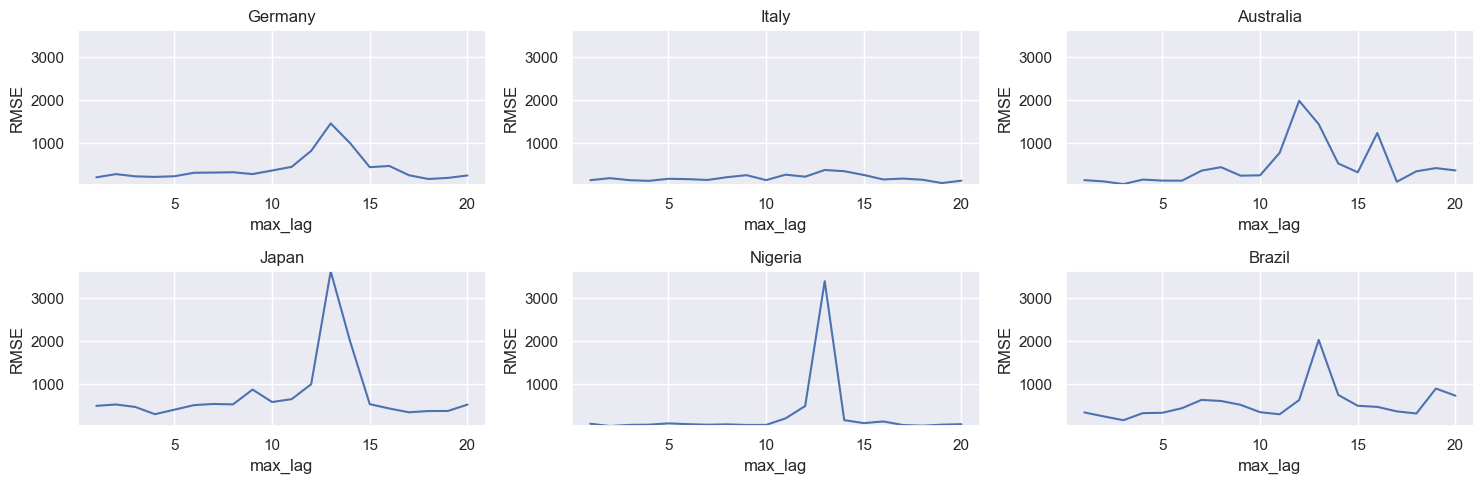

Wall time: 906 ms


In [75]:
%%time
fig, axes = plt.subplots(2, 3, figsize=(15, 5))
sns.lineplot(ax=axes[0,0], data=germany, x="max_lag", y="RMSE")
sns.lineplot(ax=axes[0,1], data=italy, x="max_lag", y="RMSE")
sns.lineplot(ax=axes[0,2], data=australia, x="max_lag", y="RMSE")
sns.lineplot(ax=axes[1,0], data=japan, x="max_lag", y="RMSE")
sns.lineplot(ax=axes[1,1], data=nigeria, x="max_lag", y="RMSE")
sns.lineplot(ax=axes[1,2], data=brazil, x="max_lag", y="RMSE")

axes[0, 0].set_title("Germany")
axes[0, 1].set_title("Italy")
axes[0, 2].set_title("Australia")
axes[1, 0].set_title("Japan")
axes[1, 1].set_title("Nigeria")
axes[1, 2].set_title("Brazil")

# Fixing the y-axis scale for all graphs
max_y_value = max(
    germany["RMSE"].max(),
    italy["RMSE"].max(),
    australia["RMSE"].max(),
    japan["RMSE"].max(),
    nigeria["RMSE"].max(),
    brazil["RMSE"].max()
)
min_y_value = min(
    germany["RMSE"].min(),
    italy["RMSE"].min(),
    australia["RMSE"].min(),
    japan["RMSE"].min(),
    nigeria["RMSE"].min(),
    brazil["RMSE"].min()
)
for ax in axes.flat:
    ax.set_ylim(min_y_value, max_y_value)

plt.tight_layout()
plt.show()

The performance of the model does not increase with the lag length. 
There is a very volatile pattern of ups and downs with a very big spike around the 13th lag for most of the countries. 

### Decision Tree

We now try out with a different model: Decision Tree.

In [76]:
%%time
from sklearn.tree import DecisionTreeRegressor

result_country_dt = {}
iterations = 20

for country_df in country_dfs:
    out_dt = pd.DataFrame(np.zeros([max_lag*iterations,3]))
    out_dt.columns = ["Country","max_lag", "RMSE"]
    country_name = country_df["Country"].iloc[0]

    for lag in range(1, max_lag+1):
        if lag % 5 == 1:
            print("max_lag = ", lag )
        X = country_df[["GDP_lag" + str(l) for l in range(1, lag+1)]].iloc[lag:]
        y = country_df["GDP"].iloc[lag:]
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)
    
      
        for i in range(iterations):
            model = DecisionTreeRegressor(random_state=i*123)
            model.fit(X_train, y_train)
            prediction = model.predict(X_test)
            out_dt.iloc[(lag-1)*iterations+i] = [country_name, lag, mean_squared_error(y_test, prediction, squared=False)]
            result_country_dt[country_name] = out_dt

max_lag =  1
max_lag =  6
max_lag =  11
max_lag =  16
max_lag =  1
max_lag =  6
max_lag =  11
max_lag =  16
max_lag =  1
max_lag =  6
max_lag =  11
max_lag =  16
max_lag =  1
max_lag =  6
max_lag =  11
max_lag =  16
max_lag =  1
max_lag =  6
max_lag =  11
max_lag =  16
max_lag =  1
max_lag =  6
max_lag =  11
max_lag =  16
max_lag =  1
max_lag =  6
max_lag =  11
max_lag =  16
max_lag =  1
max_lag =  6
max_lag =  11
max_lag =  16
max_lag =  1
max_lag =  6
max_lag =  11
max_lag =  16
max_lag =  1
max_lag =  6
max_lag =  11
max_lag =  16
max_lag =  1
max_lag =  6
max_lag =  11
max_lag =  16
max_lag =  1
max_lag =  6
max_lag =  11
max_lag =  16
max_lag =  1
max_lag =  6
max_lag =  11
max_lag =  16
max_lag =  1
max_lag =  6
max_lag =  11
max_lag =  16
max_lag =  1
max_lag =  6
max_lag =  11
max_lag =  16
max_lag =  1
max_lag =  6
max_lag =  11
max_lag =  16
max_lag =  1
max_lag =  6
max_lag =  11
max_lag =  16
max_lag =  1
max_lag =  6
max_lag =  11
max_lag =  16
max_lag =  1
max_lag =  6
ma

In [77]:
germany_dt = result_country_dt["Germany"].groupby("max_lag").mean().sort_values(by=["RMSE"])
italy_dt = result_country_dt["Italy"].groupby("max_lag").mean().sort_values(by=["RMSE"])
australia_dt = result_country_dt["Australia"].groupby("max_lag").mean().sort_values(by=["RMSE"])
japan_dt = result_country_dt["Japan"].groupby("max_lag").mean().sort_values(by=["RMSE"])
nigeria_dt = result_country_dt["Nigeria"].groupby("max_lag").mean().sort_values(by=["RMSE"])
brazil_dt = result_country_dt["Brazil"].groupby("max_lag").mean().sort_values(by=["RMSE"])

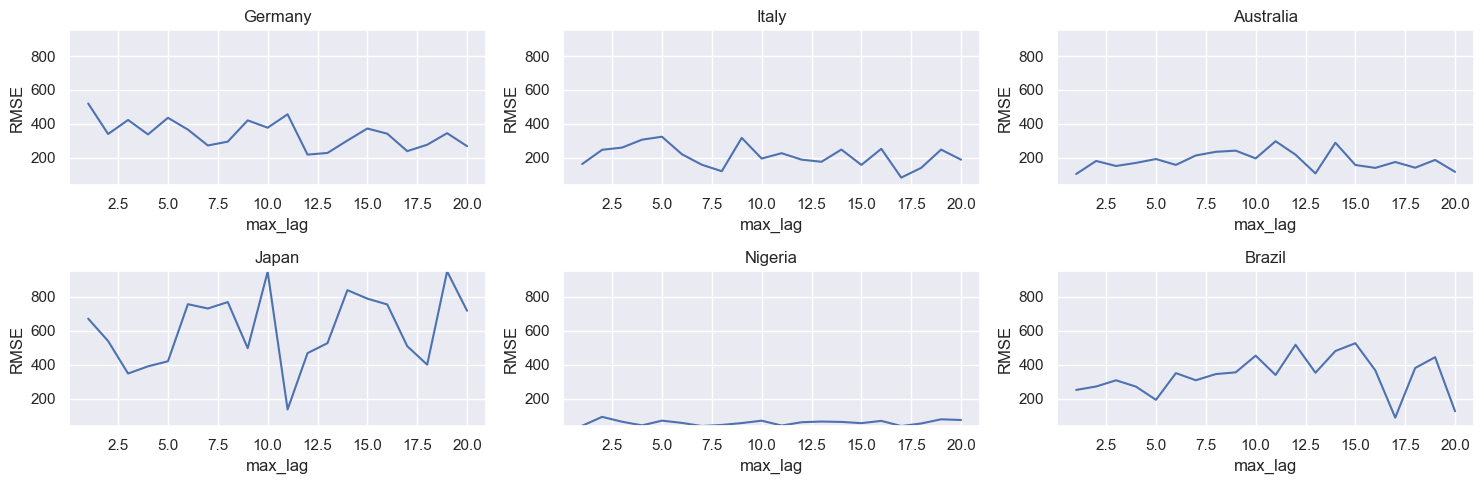

In [78]:
fig, axes = plt.subplots(2, 3, figsize=(15, 5))
sns.lineplot(ax=axes[0,0], data=germany_dt, x="max_lag", y="RMSE")
sns.lineplot(ax=axes[0,1], data=italy_dt, x="max_lag", y="RMSE")
sns.lineplot(ax=axes[0,2], data=australia_dt, x="max_lag", y="RMSE")
sns.lineplot(ax=axes[1,0], data=japan_dt, x="max_lag", y="RMSE")
sns.lineplot(ax=axes[1,1], data=nigeria_dt, x="max_lag", y="RMSE")
sns.lineplot(ax=axes[1,2], data=brazil_dt, x="max_lag", y="RMSE")

axes[0, 0].set_title("Germany")
axes[0, 1].set_title("Italy")
axes[0, 2].set_title("Australia")
axes[1, 0].set_title("Japan")
axes[1, 1].set_title("Nigeria")
axes[1, 2].set_title("Brazil")

# Fixing the y-axis scale for all graphs
max_y_value = max(
    germany_dt["RMSE"].max(),
    italy_dt["RMSE"].max(),
    australia_dt["RMSE"].max(),
    japan_dt["RMSE"].max(),
    nigeria_dt["RMSE"].max(),
    brazil_dt["RMSE"].max()
)
min_y_value = min(
    germany_dt["RMSE"].min(),
    italy_dt["RMSE"].min(),
    australia_dt["RMSE"].min(),
    japan_dt["RMSE"].min(),
    nigeria_dt["RMSE"].min(),
    brazil_dt["RMSE"].min()
)
for ax in axes.flat:
    ax.set_ylim(min_y_value, max_y_value)

# Adjust layout and spacing
plt.tight_layout()
plt.show()

The Decision Tree outperforms the Linear Regression! <br>
For further analysis we'll use this method. <br>
We also tried the Gradient Boosting method but it was very slow in the execution and didn't increase the accuracy of the predictions. 


In [79]:
#from sklearn.ensemble import GradientBoostingRegressor
#result_country_gb={}
#iterations = 20

#for country_df in country_dfs:
#    out_gb = pd.DataFrame(np.zeros([max_lag*iterations, 3])) # lag length + error + chosen learning rate 
#    out_gb.columns = ["max_lag", "learning_rate", "RMSE"]
#    country_name = country_df["Country"].iloc[0]

#    for lag in range(1, max_lag+1):
#        if lag % 5 == 1:
#            print("max_lag = ", lag )
#        X = country_df[["GDP_lag" + str(l) for l in range(1, lag+1)]].iloc[lag:]
#        y = country_df["GDP"].iloc[lag:]
#        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)
    
#        grid = pd.DataFrame(np.zeros([10, 2])) # store performance for different learning rates
#        grid.columns = ["learning_rate", "RMSE"]
#        for i, learning_rate in enumerate(np.linspace(0.1,1,10)): 
            
#            model = GradientBoostingRegressor(n_estimators=100, learning_rate=learning_rate, random_state=1234)
#            model.fit(X_train, y_train)
#            prediction = model.predict(X_test)
#            grid.iloc[i] = [learning_rate, mean_squared_error(y_test, prediction, squared=False)] # store errors
#        learning_rate = grid.sort_values(by=["RMSE"]).iloc[0]["learning_rate"]
    
#        for i in range(iterations):
#            model = GradientBoostingRegressor(n_estimators=100,
#                                          learning_rate=learning_rate,
#                                          random_state=i*123)
#            model.fit(X_train, y_train)
#            prediction = model.predict(X_test)
#            out_gb.iloc[(lag-1)*iterations + i] = [lag,
#                                            learning_rate,
#                                            mean_squared_error(y_test, prediction, squared=False)]
#            result_country_gb[country_name] = out_gb

#### b)
Now, see if you can improve the prediction with additional data. <br>
In this task, you are supposed to be creative and use your intuition. What could be important predictors? Think of, for example:
- Country characteristics such as population, unemployment rates etc. <br> *Hint: You can search for official statistics, e.g., from OECD.*
- Major historical events such as wars, natural disasters etc. <br> *Hint: You can make dummy variables if such an event happened for given country and year.*
- Geographical information such as continent.

*Note: It is well possible that you can't find data on very small countries. If you don't find data for some countries, you can drop them.*

### Adding Population, Unemployment Rate, investments for R&D, Literacy Rate and Natural disasters
We add the data regarding population, unemployment rate, Research&Development and literacy rate and dummies (stating whether there have been or not natural disasters that have had an economic impact) to check if they can improve the prediction for the 2023 GDP. 

In [80]:
country_data["Year"] = country_data.year.dt.year
country_data.drop(columns="year", inplace=True)

### UNEMPLOYMENT RATE
We upload Unemployment data from https://data.worldbank.org/indicator/SL.UEM.TOTL.ZS. 

In [81]:
unemp = pd.read_excel("unemp.xls")
# We drop unnecessary columns
unemp_clean = unemp.drop(columns=['Country Code', 'Indicator Name', 'Indicator Code'], axis=1)

# We change format of the table so that it matches the one of the GDP
unemp_melt = unemp_clean.melt(id_vars="Country Name", var_name = "Year", value_name= "Unemp_Rate", ignore_index=True )
unemp_melt["Year"] = unemp_melt["Year"].astype('int64')

# We find missing country names and different spellings between Unemployment and GDP
data_2020 = country_data[country_data["Year"] == 2020]
new_data = pd.merge(data_2020, unemp_melt, left_on="Country", right_on="Country Name", how="left")
missings = new_data[new_data["Country Name"].isnull()].index
not_found = new_data.loc[missings]
not_found["Country"]

1116         China, People's Republic of
1179             Congo, Dem. Rep. of the
1180                 Congo, Republic of 
1305                      Czech Republic
1461                               Egypt
2144                       Hong Kong SAR
2269                                Iran
2580                  Korea, Republic of
2674                          Lao P.D.R.
2892                           Macao SAR
3203          Micronesia, Fed. States of
3638                    North Macedonia 
4135               Saint Kitts and Nevis
4136                         Saint Lucia
4137    Saint Vincent and the Grenadines
4200               Sao Tome und Principe
4542            South Sudan, Republic of
4729            Taiwan Province of China
4947               Tuerkiye, Republic of
5289                           Venezuela
5352                               Yemen
Name: Country, dtype: object

In [82]:
# We fix names that are spelled differently
unemp_final = unemp_melt.replace ({ "China": "China, People's Republic of", 
                                     "Congo, Dem. Rep.": "Congo, Dem. Rep. of the",
                                     "Congo, Rep.":"Congo, Republic of ",         
                                    "Czechia":"Czech Republic",
                                    "Egypt, Arab Rep.":"Egypt",
                                  "Hong Kong SAR, China":"Hong Kong SAR",
                                   "Iran, Islamic Rep.":"Iran",
                                 "Korea, Rep.":"Korea, Republic of",
                                   "Lao PDR": "Lao P.D.R.",
                                   "Macao SAR, China":"Macao SAR",
                                   "Micronesia, Fed. Sts.":"Micronesia, Fed. States of",
                                   "St. Lucia":"Saint Lucia",
                                   "North Macedonia":"North Macedonia ",
                                    "Sao Tome and Principe": "Sao Tome und Principe",
                                   "St. Kitts and Nevis":"Saint Kitts and Nevis",
                                    "Yemen, Rep.":"Yemen",
                                    "Turkiye":"Tuerkiye, Republic of",
                                     "Venezuela, RB":"Venezuela",
                                       "St. Vincent and the Grenadines":"Saint Vincent and the Grenadines",
                                       "South Sudan":"South Sudan, Republic of"})

unemp_final.head()

,Country Name,Year,Unemp_Rate
0,Aruba,1992,NaN
1,Africa Eastern and Southern,1992,7.318747
2,Afghanistan,1992,8.168000
3,Africa Western and Central,1992,4.335460
4,Angola,1992,4.487000


### POPULATION
We upload Population data from https://data.worldbank.org/indicator/SL.UEM.TOTL.ZS 

In [83]:
population = pd.read_excel("pop.xlsx")
# We drop unnecessary columns
pop = population.drop(columns=["Country Code", "Indicator Name", "Indicator Code"])
# We put table in format similar to GDP DataFrame
melt_pop = pop.melt(id_vars=['Country Name'], var_name='Year', value_name='Population')
# We find missing country names and different spellings between Unemployment and GDP
data_2020 = country_data[country_data["Year"] == 2020]
new_data = pd.merge(data_2020, melt_pop, left_on="Country", right_on="Country Name", how="left")
missings = new_data[new_data["Country Name"].isnull()].index
not_found = new_data.loc[missings]
not_found["Country"]

1116         China, People's Republic of
1179             Congo, Dem. Rep. of the
1180                 Congo, Republic of 
1305                      Czech Republic
1461                               Egypt
2144                       Hong Kong SAR
2269                                Iran
2580                  Korea, Republic of
2674                          Lao P.D.R.
2892                           Macao SAR
3203          Micronesia, Fed. States of
3638                    North Macedonia 
4135               Saint Kitts and Nevis
4136                         Saint Lucia
4137    Saint Vincent and the Grenadines
4200               Sao Tome und Principe
4542            South Sudan, Republic of
4729            Taiwan Province of China
4947               Tuerkiye, Republic of
5289                           Venezuela
5352                               Yemen
Name: Country, dtype: object

In [84]:
melt_pop = melt_pop.replace({ "China": "China, People's Republic of", 
                                     "Congo, Dem. Rep.": "Congo, Dem. Rep. of the",
                                     "Congo, Rep.":"Congo, Republic of ",         
                                    "Czechia":"Czech Republic",
                                    "Egypt, Arab Rep.":"Egypt",
                                  "Hong Kong SAR, China":"Hong Kong SAR",
                                   "Iran, Islamic Rep.":"Iran",
                                 "Korea, Rep.":"Korea, Republic of",
                                   "Lao PDR": "Lao P.D.R.",
                                   "Macao SAR, China":"Macao SAR",
                                   "Micronesia, Fed. Sts.":"Micronesia, Fed. States of",
                                   "St. Lucia":"Saint Lucia",
                                   "North Macedonia":"North Macedonia ",
                                    "Sao Tome and Principe": "Sao Tome und Principe",
                                   "St. Kitts and Nevis":"Saint Kitts and Nevis",
                                    "Yemen, Rep.":"Yemen",
                                    "Turkiye":"Tuerkiye, Republic of",
                                     "Venezuela, RB":"Venezuela",
                                       "St. Vincent and the Grenadines":"Saint Vincent and the Grenadines",
                                       "South Sudan":"South Sudan, Republic of"})
melt_pop.head()

,Country Name,Year,Population
0,Aruba,1992,70192.0
1,Africa Eastern and Southern,1992,326933522.0
2,Afghanistan,1992,12057433.0
3,Africa Western and Central,1992,217966101.0
4,Angola,1992,12632507.0


### INFLATION
We upload Inflation data from https://data.worldbank.org/indicator/FP.CPI.TOTL.ZG

In [85]:
inflation = pd.read_excel("inflation.xls")
selected_data = inflation.loc[:, ['Country Name', 'Country Code', 'Indicator Name', 'Indicator Code'] + [str(i) for i in range(1992, 2022)]]

# We drop unnecessary columns
inf = selected_data.drop(columns=["Country Code", "Indicator Name", "Indicator Code"])
# We put table in format similar to GDP DataFrame
melt_inf = inf.melt(id_vars=['Country Name'], var_name='Year', value_name='Inflation')
# We find missing country names and different spellings between Unemployment and GDP
data_2020 = country_data[country_data["Year"] == 2020]
new_data1 = pd.merge(data_2020, melt_inf, left_on="Country", right_on="Country Name", how="left")
missings = new_data1[new_data1["Country Name"].isnull()].index
not_found = new_data1.loc[missings]
not_found["Country"]

1080         China, People's Republic of
1141             Congo, Dem. Rep. of the
1142                 Congo, Republic of 
1263                      Czech Republic
1414                               Egypt
2075                       Hong Kong SAR
2196                                Iran
2497                  Korea, Republic of
2588                          Lao P.D.R.
2799                           Macao SAR
3100          Micronesia, Fed. States of
3521                    North Macedonia 
4002               Saint Kitts and Nevis
4003                         Saint Lucia
4004    Saint Vincent and the Grenadines
4065               Sao Tome und Principe
4396            South Sudan, Republic of
4577            Taiwan Province of China
4788               Tuerkiye, Republic of
5119                           Venezuela
5180                               Yemen
Name: Country, dtype: object

In [86]:
melt_inf = melt_inf.replace({ "China": "China, People's Republic of", 
                                     "Congo, Dem. Rep.": "Congo, Dem. Rep. of the",
                                     "Congo, Rep.":"Congo, Republic of ",         
                                    "Czechia":"Czech Republic",
                                    "Egypt, Arab Rep.":"Egypt",
                                  "Hong Kong SAR, China":"Hong Kong SAR",
                                   "Iran, Islamic Rep.":"Iran",
                                 "Korea, Rep.":"Korea, Republic of",
                                   "Lao PDR": "Lao P.D.R.",
                                   "Macao SAR, China":"Macao SAR",
                                   "Micronesia, Fed. Sts.":"Micronesia, Fed. States of",
                                   "St. Lucia":"Saint Lucia",
                                   "North Macedonia":"North Macedonia ",
                                    "Sao Tome and Principe": "Sao Tome und Principe",
                                   "St. Kitts and Nevis":"Saint Kitts and Nevis",
                                    "Yemen, Rep.":"Yemen",
                                    "Turkiye":"Tuerkiye, Republic of",
                                     "Venezuela, RB":"Venezuela",
                                       "St. Vincent and the Grenadines":"Saint Vincent and the Grenadines",
                                       "South Sudan":"South Sudan, Republic of"})

melt_inf['Year'] = melt_inf['Year'].astype('int64')

melt_inf.head()

,Country Name,Year,Inflation
0,Aruba,1992,3.873375
1,Africa Eastern and Southern,1992,16.167612
2,Afghanistan,1992,NaN
3,Africa Western and Central,1992,-0.062999
4,Angola,1992,299.509804


### NATURAL DISASTER
We upload Natural Disaster data from https://ourworldindata.org/natural-disasters

In [87]:
disaster_data = pd.read_excel("natural-disasters-2.xlsx", header=1)
disaster_data_selected = disaster_data[(disaster_data['Year'] >= 1992) & (disaster_data['Year'] <= 2022)]

disaster_data_selected['Earthquake_Dummy'] = pd.notna(disaster_data_selected['Total economic damages from earthquakes']).astype(int)
disaster_data_selected['Drought_Dummy'] = pd.notna(disaster_data_selected['Total economic damages from drought']).astype(int)
disaster_data_selected['Extreme_Temp_Dummy'] = pd.notna(disaster_data_selected['Total economic damages from extreme temperatures']).astype(int)
disaster_data_selected['Floods_Dummy'] = pd.notna(disaster_data_selected['Total economic damages from floods']).astype(int)
disaster_data_selected['Landslides_Dummy'] = pd.notna(disaster_data_selected['Total economic damages from landslides']).astype(int)
disaster_data_selected['Storms_Dummy'] = pd.notna(disaster_data_selected['Total economic damages from storms']).astype(int)
disaster_data_selected['Volcanic_Activity_Dummy'] = pd.notna(disaster_data_selected['Total economic damages from volcanic activity']).astype(int)

disaster = disaster_data_selected[['Country name','Year','Earthquake_Dummy','Drought_Dummy','Extreme_Temp_Dummy','Floods_Dummy','Landslides_Dummy','Storms_Dummy','Volcanic_Activity_Dummy']].copy()

disaster.head()

,Country name,Year,Earthquake_Dummy,Drought_Dummy,Extreme_Temp_Dummy,Floods_Dummy,Landslides_Dummy,Storms_Dummy,Volcanic_Activity_Dummy
16,Afghanistan,1992,1,0,0,1,0,0,0
17,Afghanistan,1993,0,0,0,0,1,1,0
18,Afghanistan,1994,1,0,0,0,0,0,0
19,Afghanistan,1995,0,0,0,1,1,0,0
20,Afghanistan,1996,1,0,0,1,0,0,0


In [88]:
# we merge the datasets
tot_merge = pd.merge(country_data, melt_pop, left_on=["Country", "Year"], right_on=["Country Name","Year"], how="left")
tot_merge = pd.merge(tot_merge, unemp_final, left_on=["Country", "Year"], right_on=["Country Name","Year"], how="left")
tot_merge = pd.merge(tot_merge, melt_inf, left_on=["Country", "Year"], right_on=["Country Name", "Year"], how="left")
tot_merge = pd.merge(tot_merge, disaster, left_on=["Country", "Year"], right_on=["Country name", "Year"], how="left")
tot_merge.drop(columns=["Country Name_x", "Country Name_y", "Country name", "Country Name"], inplace=True)

tot_merge = tot_merge[tot_merge["Year"]>1991]

tot_merge["Earthquake_Dummy"] = tot_merge["Earthquake_Dummy"].fillna(0)
tot_merge["Drought_Dummy"] = tot_merge["Drought_Dummy"].fillna(0)
tot_merge["Extreme_Temp_Dummy"] = tot_merge["Extreme_Temp_Dummy"].fillna(0)
tot_merge["Floods_Dummy"] = tot_merge["Floods_Dummy"].fillna(0)
tot_merge["Landslides_Dummy"] = tot_merge["Landslides_Dummy"].fillna(0)
tot_merge["Storms_Dummy"] = tot_merge["Storms_Dummy"].fillna(0)
tot_merge["Volcanic_Activity_Dummy"] = tot_merge["Volcanic_Activity_Dummy"].fillna(0)

tot_merge.to_excel('tot_merge1.xlsx', index=False)

### CONTINENTS
We add the name of the continent each country belongs to.

In [89]:
!pip install country_converter
import country_converter as coco

converter = coco.CountryConverter()

# Replace "Tuerkiye, Republic of" with "Turkey"
tot_merge['Country'] = tot_merge['Country'].replace('Tuerkiye, Republic of', 'Turkey')

# We add column with Continent for every country every year
tot_merge['Continent'] = tot_merge['Country'].apply(lambda x: converter.convert(names=x, to='continent'))

print(tot_merge.head())
tot_merge

       Country    GDP  Year  Population  Unemp_Rate  Inflation  \
0  Afghanistan  4.367  2002  21000256.0       8.186        NaN   
1  Afghanistan  4.553  2003  22645130.0       8.122        NaN   
2  Afghanistan  5.146  2004  23553551.0       8.053        NaN   
3  Afghanistan  6.167  2005  24411191.0       8.113  12.686269   
4  Afghanistan  6.925  2006  25442944.0       8.054   6.784597   

   Earthquake_Dummy  Drought_Dummy  Extreme_Temp_Dummy  Floods_Dummy  \
0               1.0            0.0                 0.0           1.0   
1               1.0            0.0                 0.0           1.0   
2               1.0            0.0                 0.0           1.0   
3               1.0            0.0                 1.0           1.0   
4               1.0            1.0                 0.0           1.0   

   Landslides_Dummy  Storms_Dummy  Volcanic_Activity_Dummy Continent  
0               1.0           0.0                      0.0      Asia  
1               0.0         

,Country,GDP,Year,Population,Unemp_Rate,Inflation,Earthquake_Dummy,Drought_Dummy,Extreme_Temp_Dummy,Floods_Dummy,Landslides_Dummy,Storms_Dummy,Volcanic_Activity_Dummy,Continent
0,Afghanistan,4.367,2002,21000256.0,8.186,NaN,1.0,0.0,0.0,1.0,1.0,0.0,0.0,Asia
1,Afghanistan,4.553,2003,22645130.0,8.122,NaN,1.0,0.0,0.0,1.0,0.0,0.0,0.0,Asia
2,Afghanistan,5.146,2004,23553551.0,8.053,NaN,1.0,0.0,0.0,1.0,0.0,0.0,0.0,Asia
3,Afghanistan,6.167,2005,24411191.0,8.113,12.686269,1.0,0.0,1.0,1.0,0.0,1.0,0.0,Asia
4,Afghanistan,6.925,2006,25442944.0,8.054,6.784597,1.0,1.0,0.0,1.0,1.0,1.0,0.0,Asia
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5878,Zimbabwe,36.945,2018,15052184.0,6.784,10.618866,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Africa
5879,Zimbabwe,26.032,2019,15354608.0,7.370,255.304991,0.0,0.0,0.0,1.0,0.0,1.0,0.0,Africa
5880,Zimbabwe,26.878,2020,15669666.0,7.898,557.201817,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Africa
5881,Zimbabwe,35.967,2021,15993524.0,8.067,98.546105,0.0,1.0,0.0,0.0,0.0,1.0,0.0,Africa


In [90]:
# Get the unique country names
country_name = tot_merge['Country'].unique()

country_df = []

target_year = 2023

for country in country_name:
    
    target_data = tot_merge[(tot_merge["Country"] == country) & (tot_merge["Year"] < target_year)]

    # We drop column if value of Unemp Rate, Population or Inflations is null
    target_data = target_data.dropna(subset=['Unemp_Rate', 'Population', "Inflation"])
    # We count numbers of remaining rows
    num_values = target_data.shape[0]
    
    # Only add the processed dataframe to the list if it has at least 22 values [otherwise we'd get error afterwards]
    if num_values > 21:
        max_lag = 20
        for l in range(1, max_lag+1):
            target_data["GDP_lag"+str(l)] = target_data.GDP.shift(l)
            target_data["Unemp_lag"+str(l)] = target_data.Unemp_Rate.shift(l)
            target_data["Pop_lag"+str(l)] = target_data.Population.shift(l)
            target_data["Inf_lag"+str(l)] = target_data.Inflation.shift(l)
        
        # Append the processed dataframe to the list
        country_df.append(target_data)

In [91]:
from sklearn.tree import DecisionTreeRegressor

# list to store results for each country
result_country_tot = {}
iterations = 20
max_lag = 20

# iterate over each country dataframe
for target_data in country_df:

    out_tot = pd.DataFrame(np.zeros([max_lag*iterations,3]))
    out_tot.columns = ["Country","max_lag", "RMSE"]
    country_name = target_data["Country"].iloc[0]
    print(country_name)

    for lag in range(1, max_lag+1):
        if lag % 5 == 1:
            print("max_lag = ", lag )

        X = target_data[["GDP_lag" + str(l) for l in range(1, lag+1)] + 
                        ["Pop_lag" + str(l) for l in range(1, lag+1)]+ 
                        ["Unemp_lag" + str(l) for l in range(1, lag+1)] + 
                        ["Inf_lag" + str(l) for l in range(1, lag+1)] +
                        ["Earthquake_Dummy", "Drought_Dummy","Extreme_Temp_Dummy", "Floods_Dummy", "Landslides_Dummy","Storms_Dummy", "Volcanic_Activity_Dummy"]].iloc[lag:]
        y = target_data["GDP"].iloc[lag:]
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)
    
        # Fit the model
        for i in range(iterations):
            model = DecisionTreeRegressor(random_state=i*123)
            model.fit(X_train, y_train)
            prediction = model.predict(X_test)
            out_tot.iloc[(lag-1)*iterations+i] = [country_name, lag, mean_squared_error(y_test, prediction, squared=False)]
            result_country_tot[country_name] = out_tot

Albania
max_lag =  1
max_lag =  6
max_lag =  11
max_lag =  16
Algeria
max_lag =  1
max_lag =  6
max_lag =  11
max_lag =  16
Angola
max_lag =  1
max_lag =  6
max_lag =  11
max_lag =  16
Armenia
max_lag =  1
max_lag =  6
max_lag =  11
max_lag =  16
Australia
max_lag =  1
max_lag =  6
max_lag =  11
max_lag =  16
Austria
max_lag =  1
max_lag =  6
max_lag =  11
max_lag =  16
Azerbaijan
max_lag =  1
max_lag =  6
max_lag =  11
max_lag =  16
Bahamas, The
max_lag =  1
max_lag =  6
max_lag =  11
max_lag =  16
Bahrain
max_lag =  1
max_lag =  6
max_lag =  11
max_lag =  16
Bangladesh
max_lag =  1
max_lag =  6
max_lag =  11
max_lag =  16
Barbados
max_lag =  1
max_lag =  6
max_lag =  11
max_lag =  16
Belarus
max_lag =  1
max_lag =  6
max_lag =  11
max_lag =  16
Belgium
max_lag =  1
max_lag =  6
max_lag =  11
max_lag =  16
Belize
max_lag =  1
max_lag =  6
max_lag =  11
max_lag =  16
Benin
max_lag =  1
max_lag =  6
max_lag =  11
max_lag =  16
Bhutan
max_lag =  1
max_lag =  6
max_lag =  11
max_lag =  16

In [92]:
germany_tot = result_country_tot["Germany"].groupby("max_lag").mean().sort_values(by=["RMSE"])
italy_tot = result_country_tot["Italy"].groupby("max_lag").mean().sort_values(by=["RMSE"])
australia_tot = result_country_tot["Australia"].groupby("max_lag").mean().sort_values(by=["RMSE"])
japan_tot = result_country_tot["Japan"].groupby("max_lag").mean().sort_values(by=["RMSE"])
nigeria_tot = result_country_tot["Nigeria"].groupby("max_lag").mean().sort_values(by=["RMSE"])
brazil_tot = result_country_tot["Brazil"].groupby("max_lag").mean().sort_values(by=["RMSE"])

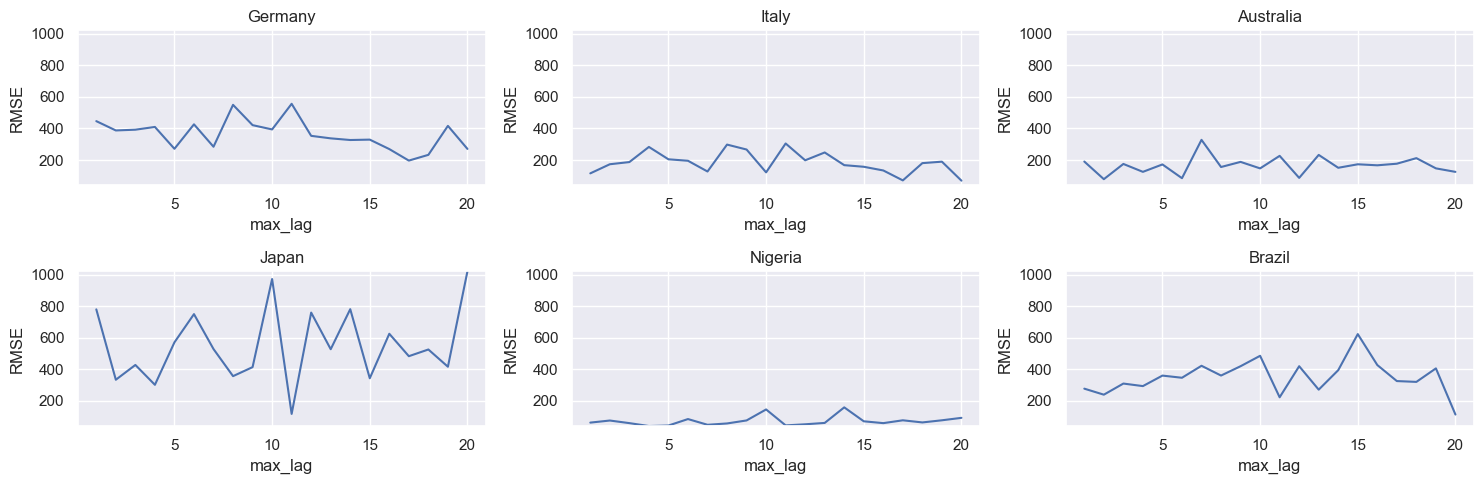

In [93]:
fig, axes = plt.subplots(2, 3, figsize=(15, 5))
sns.lineplot(ax=axes[0,0], data=germany_tot, x="max_lag", y="RMSE")
sns.lineplot(ax=axes[0,1], data=italy_tot, x="max_lag", y="RMSE")
sns.lineplot(ax=axes[0,2], data=australia_tot, x="max_lag", y="RMSE")
sns.lineplot(ax=axes[1,0], data=japan_tot, x="max_lag", y="RMSE")
sns.lineplot(ax=axes[1,1], data=nigeria_tot, x="max_lag", y="RMSE")
sns.lineplot(ax=axes[1,2], data=brazil_tot, x="max_lag", y="RMSE")

axes[0, 0].set_title("Germany")
axes[0, 1].set_title("Italy")
axes[0, 2].set_title("Australia")
axes[1, 0].set_title("Japan")
axes[1, 1].set_title("Nigeria")
axes[1, 2].set_title("Brazil")

# Fixing the y-axis scale for all graphs
max_y_value = max(
    germany_tot["RMSE"].max(),
    italy_tot["RMSE"].max(),
    australia_tot["RMSE"].max(),
    japan_tot["RMSE"].max(),
    nigeria_tot["RMSE"].max(),
    brazil_tot["RMSE"].max()
)
min_y_value = min(
    germany_tot["RMSE"].min(),
    italy_tot["RMSE"].min(),
    australia_tot["RMSE"].min(),
    japan_tot["RMSE"].min(),
    nigeria_tot["RMSE"].min(),
    brazil_tot["RMSE"].min()
)
for ax in axes.flat:
    ax.set_ylim(min_y_value, max_y_value)

# Adjust layout and spacing
plt.tight_layout()
plt.show()

Adding all these information doesn't seem to improve our results much. <br>
We're probably still missing some variables that could help us better predict future GDP.


# Problem 4 - Unsupervised Machine Learning
Use GDP and the information from Problem 3b) to cluster countries. <br>
Which is the optimal number of clusters? <br>
Can you provide an intuition for the clusters you identified?

We use data from 3b) <br>
First we normalize variables. 

In [94]:
tot_merge.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5883 entries, 0 to 5882
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Country                  5883 non-null   object 
 1   GDP                      5883 non-null   float64
 2   Year                     5883 non-null   int64  
 3   Population               5833 non-null   float64
 4   Unemp_Rate               5427 non-null   float64
 5   Inflation                5078 non-null   float64
 6   Earthquake_Dummy         5883 non-null   float64
 7   Drought_Dummy            5883 non-null   float64
 8   Extreme_Temp_Dummy       5883 non-null   float64
 9   Floods_Dummy             5883 non-null   float64
 10  Landslides_Dummy         5883 non-null   float64
 11  Storms_Dummy             5883 non-null   float64
 12  Volcanic_Activity_Dummy  5883 non-null   float64
 13  Continent                5883 non-null   object 
dtypes: float64(11), int64(1)

We have the following issues: 
- Country and Continent are strings that we have to either turn into dummies or categorical, numerical variables
- We have some missing values for Unemployment Rate and Inflation. We'll drop these observations.
<br>

First we drop rows with missing values.

In [95]:
tot_merge = tot_merge.dropna()
tot_merge.isna().sum().sum()

0

In [96]:
# We create dummies for the continents
tot_merge["Africa"] = (tot_merge.Continent == "Africa").astype(int)
tot_merge["Europe"] = (tot_merge.Continent == "Europe").astype(int)
tot_merge["America"] = (tot_merge.Continent == "America").astype(int)
tot_merge["Asia"] = (tot_merge.Continent == "Asia").astype(int)
tot_merge["Oceania"] = (tot_merge.Continent == "Oceania").astype(int)
tot_merge = tot_merge.drop(columns = ["Continent"])
tot_merge.reset_index(drop=True)

,Country,GDP,Year,Population,Unemp_Rate,Inflation,Earthquake_Dummy,Drought_Dummy,Extreme_Temp_Dummy,Floods_Dummy,Landslides_Dummy,Storms_Dummy,Volcanic_Activity_Dummy,Africa,Europe,America,Asia,Oceania
0,Afghanistan,6.167,2005,24411191.0,8.113,12.686269,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0,0,0,1,0
1,Afghanistan,6.925,2006,25442944.0,8.054,6.784597,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0,0,0,1,0
2,Afghanistan,8.556,2007,25903301.0,8.108,8.680571,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0,0,0,1,0
3,Afghanistan,10.297,2008,26427199.0,8.022,26.418664,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0,0,0,1,0
4,Afghanistan,12.066,2009,27385307.0,8.082,-6.811161,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4816,Zimbabwe,21.385,2017,14751101.0,6.279,0.893962,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1,0,0,0,0
4817,Zimbabwe,36.945,2018,15052184.0,6.784,10.618866,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0
4818,Zimbabwe,26.032,2019,15354608.0,7.370,255.304991,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1,0,0,0,0
4819,Zimbabwe,26.878,2020,15669666.0,7.898,557.201817,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0


We selected one year to do our clustering on.

In [97]:
# YEAR 2020
data2020 = tot_merge[tot_merge["Year"] == 2020]
data2020.reset_index(inplace = True, drop=True)
data2020.head()

,Country,GDP,Year,Population,Unemp_Rate,Inflation,Earthquake_Dummy,Drought_Dummy,Extreme_Temp_Dummy,Floods_Dummy,Landslides_Dummy,Storms_Dummy,Volcanic_Activity_Dummy,Africa,Europe,America,Asia,Oceania
0,Albania,15.161,2020,2837849.0,13.067,1.620887,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0,0,0
1,Algeria,145.656,2020,43451666.0,12.248,2.415131,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0
2,Angola,57.139,2020,33428486.0,10.350,22.271564,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1,0,0,0,0
3,Armenia,12.642,2020,2805608.0,12.180,1.211436,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0,0,0,1,0
4,Australia,1360.687,2020,25655289.0,6.460,0.846906,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0,0,0,0,1


In [98]:
data2020.drop(columns = ["Country", "Year"], inplace=True)
data2020.head()

,GDP,Population,Unemp_Rate,Inflation,Earthquake_Dummy,Drought_Dummy,Extreme_Temp_Dummy,Floods_Dummy,Landslides_Dummy,Storms_Dummy,Volcanic_Activity_Dummy,Africa,Europe,America,Asia,Oceania
0,15.161,2837849.0,13.067,1.620887,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0,0,0
1,145.656,43451666.0,12.248,2.415131,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0
2,57.139,33428486.0,10.350,22.271564,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1,0,0,0,0
3,12.642,2805608.0,12.180,1.211436,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0,0,0,1,0
4,1360.687,25655289.0,6.460,0.846906,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0,0,0,0,1


We normalize the variables. 

In [99]:
from sklearn.preprocessing import StandardScaler

cols = data2020.columns
scaler = StandardScaler()
scaled_data = scaler.fit(data2020)  
data2020_norm = scaler.transform(data2020)

data2020_norm = pd.DataFrame(data2020_norm, columns=cols)  
data2020_norm.head()

,GDP,Population,Unemp_Rate,Inflation,Earthquake_Dummy,Drought_Dummy,Extreme_Temp_Dummy,Floods_Dummy,Landslides_Dummy,Storms_Dummy,Volcanic_Activity_Dummy,Africa,Europe,America,Asia,Oceania
0,-0.238657,-0.267303,0.884232,-0.148194,-0.212512,-0.256495,-0.159111,-0.894427,-0.282843,-0.629724,-0.137361,-0.629724,1.775907,-0.447214,-0.591608,-0.227921
1,-0.176299,-0.013493,0.738936,-0.130859,4.705620,-0.256495,-0.159111,-0.894427,-0.282843,-0.629724,-0.137361,1.587998,-0.563093,-0.447214,-0.591608,-0.227921
2,-0.218597,-0.076131,0.402218,0.302530,-0.212512,3.898718,-0.159111,1.118034,-0.282843,-0.629724,-0.137361,1.587998,-0.563093,-0.447214,-0.591608,-0.227921
3,-0.239861,-0.267505,0.726872,-0.157131,-0.212512,-0.256495,-0.159111,-0.894427,-0.282843,1.587998,-0.137361,-0.629724,-0.563093,-0.447214,1.690309,-0.227921
4,0.404312,-0.124709,-0.287894,-0.165087,-0.212512,-0.256495,-0.159111,1.118034,-0.282843,1.587998,-0.137361,-0.629724,-0.563093,-0.447214,-0.591608,4.387482


### PCA
We will first apply dimensionality reduction with PCA. <br>
Through the Elbow method we'll try to identify the optimal number of components, since the results in 3b) tells us that some of the added variables might not be that useful. 

In [100]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=16)
pca.fit(data2020_norm)
print("Share of variance explained by each component: ", pca.explained_variance_ratio_*100)
print("Share of variance explained by all components: ", sum(pca.explained_variance_ratio_*100))

Share of variance explained by each component:  [1.36989300e+01 1.16692006e+01 1.03289695e+01 9.02770295e+00
 8.31789164e+00 8.02457973e+00 6.35617587e+00 5.98741062e+00
 5.42082233e+00 4.70218235e+00 4.04862952e+00 3.88203627e+00
 3.33233649e+00 3.24925984e+00 1.95387228e+00 6.22665207e-31]
Share of variance explained by all components:  99.99999999999997


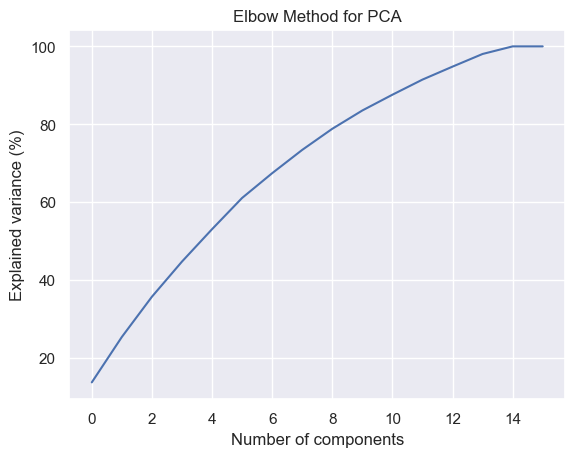

In [101]:
plt.plot(np.cumsum(pca.explained_variance_ratio_*100))
plt.xlabel("Number of components")
plt.ylabel("Explained variance (%)")
plt.title("Elbow Method for PCA")
plt.show()

We can't delete any component without losing information. 

### k-Means Clustering

We try to find the optimal $k$ by applying the elbow method. 

In [102]:
from sklearn.cluster import KMeans
distortions = []
K = range(1,20)
for k in K:
    kmeans= KMeans(n_clusters=k, n_init=10, random_state=123)
    kmeans.fit(data2020_norm)
    distortions.append(kmeans.inertia_)


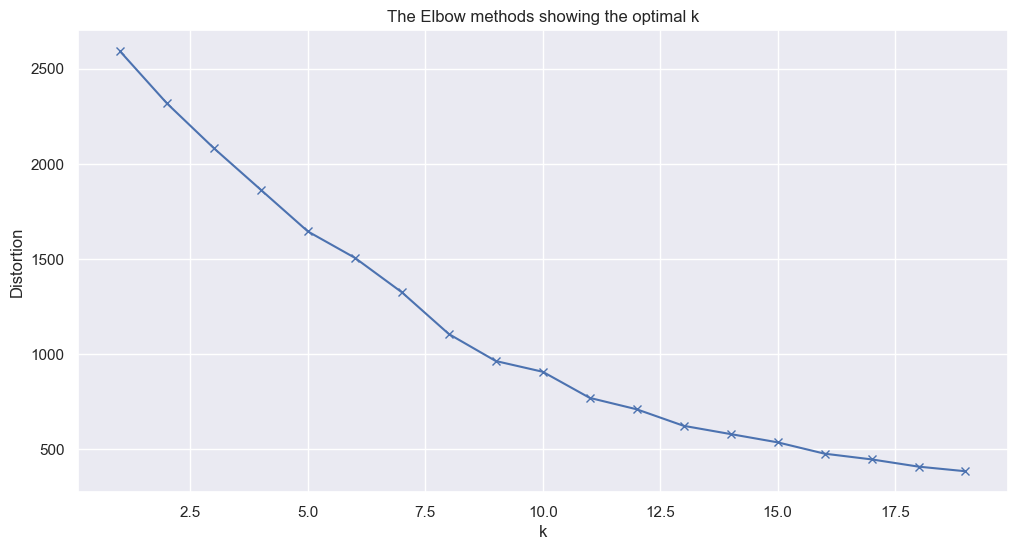

In [103]:
plt.figure(figsize=(12,6))
plt.plot(K, distortions, "bx-")
plt.xlabel("k")
plt.ylabel("Distortion")
plt.title("The Elbow methods showing the optimal k")
plt.show()


The optimal value of $k$ seems to be for $k=10$. 

In [104]:
kmeans = KMeans(n_clusters=10, random_state=0).fit(data2020_norm)

In [105]:
# Create a new column 'Cluster' in the original dataset 
data2020['Cluster'] = kmeans.labels_

# Group by 'Cluster' and calculate the mean
grouped = data2020.groupby('Cluster').mean()

# Print the grouped data
print(grouped)

                  GDP    Population  Unemp_Rate   Inflation  Earthquake_Dummy  \
Cluster                                                                         
0          406.170971  1.657878e+07    7.648914    1.178350          0.057143   
1           58.839378  2.837043e+07    9.796189   10.356534          0.027027   
2        12864.870000  1.046333e+09    7.748333    3.425481          0.000000   
3          200.375625  5.342326e+06    4.238000    1.401519          0.000000   
4          337.527737  3.285091e+07    6.840974    5.442309          0.026316   
5          180.061222  4.220680e+07    7.698000    5.083731          0.000000   
6         1694.079750  4.090811e+07    5.463000    0.869809          0.000000   
7          166.664042  1.533775e+07   10.425958    4.140958          0.041667   
8          507.858000  1.338792e+08    4.293333    1.325086          0.666667   
9           26.878000  1.566967e+07    7.898000  557.201817          0.000000   

         Drought_Dummy  Ext

In the 10 resulting clusters we have: <br>

0) countries from Europe with high GDP and average Unemployment Rate so probably rich countries
1) African countries with low GDP that experienced floodings, have high inflation and unemployment rate
2) a mix of countries from Asia and America where inflation is low and GDP very high. Floods and extreme temperature lead to economic damages
3) countries from Oceania. Unemployment rate is low. 
4) countries from Asia with average level of GDP, that experienced earthquakes 
5) countries from mostly from Africa but also from America that often experienced drought and floods
6) European countries with very low inflation and very high GDP
7) American countries with low GDP and high unemployment rate 
8) Asian and American countries that had damages due to vulcanic activity 
9) very poor African countries with super high inflation
